In [1]:
# the source is from A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
%matplotlib ipympl

from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math


def lk(E=1, nu=0.3):
    """
    The function computes the stiffness matrix for Q4 element
    with given material properties:
        E is Youngs Modulus;
        nu is Poisson's ratio.

    return:
        stiffniss matirix - np.array with shape (8, 8) 
    """
    # E=1 # ! need to synchronize material properties !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ])
    return (KE)


def oc(nelx,nely,x,volfrac,dc,dv,g):
    """
    The function finds next X for optimization in SIMP method
    and upadates optimality criterion.
    """
    l1=0
    l2=1e9
    move=0.2
    # reshape to perform vector operations
    xnew=np.zeros(nelx*nely)
    while (l2-l1)/(l1+l2)>1e-3:
        lmid=0.5*(l2+l1)
        xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))

        gt=g+np.sum((dv*(xnew-x)))
        if gt>0 :
            l1=lmid
        else:
            l2=lmid
    return (xnew,gt)

def el_mask_2_nod_mask(el_mask, nelx, nely, ndof):
    """
    The function converts mask of void elements to
    mask of void nodes. It is used for postprocessing
    Inputs:
        el_mask - np.array, (nelx, nely), 0 if the element is void, 1 if element is material
        nelx    - int, element number per row
        nely    - int, element number per column
        ndof    - int, number of dofs (degrees of freedom)

    Return:
        node_mask - np.array, (number_of_nodes, 1), 0 if the node is void, 1 if the node is material 
    """
    node_mask = np.zeros((int(ndof/2), 1))
    for elx in range(nelx):
        for ely in range(nely):
            if el_mask[elx, ely] == 0:
                continue
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely

            node_mask[n1] = 1
            node_mask[n2] = 1
            node_mask[n1 + 1] = 1
            node_mask[n2 + 1] = 1

    return node_mask

def gradshape(xi):
    """
    Gradient of the shape functions for a 4-node, isoparametric element.
    dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
    Input: 
        xi  - np.array, (1, 2),  
    Return: 
        dn  - np.array, (2, 4).
    """
    xi,eta = tuple(xi)
    dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
          [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
    return 0.25 * np.array(dN)

class topology_AAGE:
    """
    The class for topology optimization 2D by using SIMP strategy.
    """

    def __init__(self, nelx, nely, volfrac, penal, rmin, ft):
        """
        The function initializes the problem and optimization.
        Input:
            nelx    - int, number of elements per row;
            nely    - int, number of elements per column;
            vofrac  - float, volume fraction;
            penal   - float > 1, penalty coeffs;
            rmin    - float, min radius (used to build index-data vector)
        """
        print("Minimum compliance problem with OC")
        print("ndes: " + str(nelx) + " x " + str(nely))
        print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
        print("Filter method: " + ["Sensitivity based","Density based"][ft])

        self.penal = penal
        self.rmin = rmin
        self.ft = ft
        self.nelx = nelx
        self.nely = nely
        self.volfrac = volfrac
        self.cell_size = 1  # edge size for one element

        # Young's modulus and Poissnon's ratio
        E = 1   # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 100
        v = 0.3

        # Max and min stiffness
        self.Emin=1e-9
        self.Emax=1.0

        # number of dofs:
        self.ndof = 2*(nelx+1)*(nely+1)

        # Allocate design variables (as array), initialize and allocate sens.
        self.x=self.volfrac * np.ones(nely*nelx,dtype=float)
        self.xold=self.x.copy()
        self.xPhys=self.x.copy()
        self.xPhys_previous=self.x.copy()
        self.g=0 # must be initialized to use the NGuyen/Paulino OC approach
        self.dc=np.zeros((nely,nelx), dtype=float)

        # FE: Build the index vectors for the for coo matrix format.
        self.KE=lk(E, v)
        self.edofMat=np.zeros((nelx*nely,8),dtype=int)
        self.conn = []  # matrix of element (row corresponds to the element, column corresponds to the indeces of nodes)
        self.coords = np.zeros((self.ndof,1))   # coords for each dof (even - X, odd - Y)

        for elx in range(nelx):
            for ely in range(nely):     # iterate each Q4 element
                el = ely+elx*nely
                n1=(nely+1)*elx+ely
                n2=(nely+1)*(elx+1)+ely

                # save indeces of nodes for each element
                self.edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

                # save indeces of nodes for element
                self.conn.append([n2, n1, n1 + 1, n2 + 1])

                # center of the node
                x_center = self.cell_size/2 + self.cell_size * elx
                y_center = - self.cell_size/2 - self.cell_size * ely

                # save x coords of node
                self.coords[2*n1+2] = x_center - self.cell_size/2
                self.coords[2*n2+2] = x_center + self.cell_size/2
                self.coords[2*n2] = x_center + self.cell_size/2
                self.coords[2*n1] = x_center - self.cell_size/2

                # save y coords of node
                self.coords[2*n1+3] = y_center - self.cell_size/2
                self.coords[2*n2+3] = y_center - self.cell_size/2
                self.coords[2*n2+1] = y_center + self.cell_size/2
                self.coords[2*n1+1] = y_center + self.cell_size/2

        # Construct the index pointers for the coo format
        self.iK = np.kron(self.edofMat,np.ones((8,1))).flatten()
        self.jK = np.kron(self.edofMat,np.ones((1,8))).flatten()

        # Filter: Build (and assemble) the index+data vectors for the coo matrix format
        self.nfilter=int(self.nelx*self.nely*((2*(np.ceil(self.rmin)-1)+1)**2))
        self.iH = np.zeros(self.nfilter)
        self.jH = np.zeros(self.nfilter)
        self.sH = np.zeros(self.nfilter)
        cc=0
        for i in range(self.nelx):
            for j in range(self.nely):
                row=i*self.nely+j
                kk1=int(np.maximum(i-(np.ceil(self.rmin)-1),0))
                kk2=int(np.minimum(i+np.ceil(self.rmin),nelx))
                ll1=int(np.maximum(j-(np.ceil(self.rmin)-1),0))
                ll2=int(np.minimum(j+np.ceil(self.rmin), self.nely))
                for k in range(kk1,kk2):
                    for l in range(ll1,ll2):
                        col=k*self.nely+l
                        fac=self.rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                        self.iH[cc]=row
                        self.jH[cc]=col
                        self.sH[cc]=np.maximum(0.0,fac)
                        cc=cc+1

        # Finalize assembly and convert to csc format
        self.H=coo_matrix((self.sH,(self.iH,self.jH)),shape=(self.nelx*self.nely,self.nelx*self.nely)).tocsc()
        self.Hs=self.H.sum(1)

        # initialize the problem
        self.init_problem()

        # Set loop counter and gradient vectors
        self.loop=0
        self.change=1
        self.dv = np.ones(self.nely*self.nelx)
        self.dc = np.ones(self.nely*self.nelx)
        self.ce = np.ones(self.nely*self.nelx)

        self.obj = 0    # objective function value

        # Set parameters for postprocessing
        self.coord_disp = np.zeros((self.ndof,1))

        # 2x2 Gauss Quadrature (4 Gauss points)
        self.q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0) # q4 is 4x2

        ###############################
        # Plane-strain material tangent (see Bathe p. 194)
        # C is 3x3
        self.C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])

        # (pre-allocate space for nodal stress and strain)
        node_strain = []
        node_stress = []
        for ni in range(int(self.ndof/2)):              # could be done in more proper way
            node_strain.append([0.0, 0.0, 0.0])
            node_stress.append([0.0, 0.0, 0.0])
        self.node_strain = np.array(node_strain)
        self.node_stress = np.array(node_stress)

        # allocate history variables ## it should be removed for large problems
        self.u_hist = []
        self.xPhys_hist = []
        self.itn_hist = []
        self.obj_hist = []
        self.time_hist = []

    def init_problem(self):
        """
        The function initialize the FEA problem
        """

        
        self.dofs=np.arange(2*(self.nelx+1)*(self.nely+1))

        # BC's and support (Boundary conditions)
        # fix movement of the right edge by x-axis and left-down node in x,y axes

        self.fixed=np.union1d(self.dofs[0:2*(self.nely+1):2],np.array([2*(self.nelx+1)*(self.nely+1)-1]))   # indeces of fixed dofs
        self.free=np.setdiff1d(self.dofs, self.fixed)                                                       # free indeces are all others

        # Solution and RHS vectors
        self.f=np.zeros((self.ndof,1))  # vector of loads for each dof
        self.u=np.zeros((self.ndof,1))  # vector of displacements for each dof
        # Set load
        self.f[1,0]=-1                  # load down with 1 module only for right-up node
        

    def optimization_step(self):
        """
        The function excute the optimization step.
        """

        # Setup and solve FE problem
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(self.xPhys)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()

        # Remove constrained dofs from matrix
        K = K[self.free,:][:,self.free]

        # Solve system
        self.u[self.free,0]=spsolve(K,self.f[self.free,0])

        # Objective and sensitivity
        self.ce[:] = (np.dot(self.u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)
        self.obj=( (self.Emin+self.xPhys**self.penal*(self.Emax-self.Emin))*self.ce ).sum()
        self.dc[:]=(-self.penal*self.xPhys**(self.penal-1)*(self.Emax-self.Emin))*self.ce
        self.dv[:] = np.ones(self.nely*self.nelx)

        # Sensitivity filtering:
        if self.ft==0:  # Sensitivity based
            self.dc[:] = np.asarray((self.H*(self.x*self.dc))[np.newaxis].T/self.Hs)[:,0] / np.maximum(0.001,self.x)
        elif self.ft==1:    # Density based
            self.dc[:] = np.asarray(self.H*(self.dc[np.newaxis].T/self.Hs))[:,0]
            self.dv[:] = np.asarray(self.H*(self.dv[np.newaxis].T/self.Hs))[:,0]

        # Optimality criteria
        self.xold[:]=self.x
        (self.x[:], self.g)=oc(self.nelx,self.nely,self.x,self.volfrac,self.dc,self.dv, self.g)

        # save the previous result
        self.xPhys_previous = self.xPhys.copy()

        # Filter design variables
        if self.ft==0:   self.xPhys[:]=self.x # Sensitivity based
        elif self.ft==1:	self.xPhys[:]=np.asarray(self.H*self.x[np.newaxis].T/self.Hs)[:,0] # Density based

        # Compute the change by the inf. norm
        self.change=np.linalg.norm(self.x.reshape(self.nelx*self.nely,1)-self.xold.reshape(self.nelx*self.nely,1),np.inf)
        # save iteration index
        self.loop=self.loop+1

    def optimization(self, n_iter, trsh_chang = 0.01, history_step=5):
        """
        The function excutes optimization iterations and saves history.
        Input:
            n_iter          - int, iteration number;
            trsh_chan       - float, when changes are small stop optimization;
            history_step    - int, increment for history savings (used to save memory)
        """


        if self.change < trsh_chang: # is more accurete to added thrsh by obj or final mass percentage
             print("The result is achieved")
        local_loop = 0
        while local_loop<n_iter: #self.change>trsh_chang and 
            self.optimization_step()
            print("Iteration N: ", self.loop, "\t optimizer: TopoSIMP \t Objective function value: ", self.obj)

            # save history
            if self.loop%history_step == 0 or local_loop == 0:
                self.u_hist.append(self.u.copy())
                self.xPhys_hist.append(self.xPhys.copy())
                self.itn_hist.append(self.loop)
                self.obj_hist.append(self.obj)

            local_loop += 1

    def implement_solution(self, new_xPhys, n_iter, remove_history=False):
        """
        The function rechanges the current solution by outer one.
        Input:
            new_xPhys       - np.array, (number of elements, 1) [0, 1] out solution;
            n_iter          - int, new index of iteration (it is necessary if few optimizers are used);
            remove_historu  - bool, if it is True, clear history.
        """

        self.xPhys = new_xPhys
        self.loop = n_iter      

        if remove_history == True:
            self.u_hist = []
            self.xPhys_hist = []
            self.itn_hist = []
            self.obj_hist = []
            self.time_hist = []

    def get_history(self):
        """
        The function returns history of previous iterations.
        """
        
        return [self.xPhys_hist, self.itn_hist, self.obj_hist]

    def estimate_out_solution(self, out_xPhys, return_disp = False):
        """
        The function estimates outer xPhys without implementating of it.
        Input:
            out_xPhys       - np.array, (number of elements, 1) [0, 1] out solution;
            return_disp     - bool, if it is necessary to get displacements;
        """
        # allocate variables
        ce = np.ones(self.nely*self.nelx)
        u=np.zeros((self.ndof,1))

        # Setup and solve FE problem
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(out_xPhys)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()

        # Remove constrained dofs from matrix
        K = K[self.free,:][:,self.free]

        # Solve system
        u[self.free,0]=spsolve(K,self.f[self.free,0])

        # Objective and sensitivity
        ce[:] = (np.dot(u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)
        obj=( (self.Emin+out_xPhys**self.penal*(self.Emax-self.Emin))*ce ).sum()

        if return_disp:
             return obj, u

        else:
             return obj

    def get_obj(self):
        """
        The function returns the current objective function value.
        Returns:
            - self.obj, float
        """
        return self.obj

    def get_data_for_NN(self, nn_shape=[40, 40]):
        """
        The function returns the data for the NN optimizer step X and delta_X.
        Input:
            nn_shape    - list, shape of NN input
        Return:
            x           - np.array, (nelx_x, nel_y), current reshaped xPhys;
            delta_X     - np.array, (nelx_x, nel_y), difference with prevous xPhys;
            loop        - int, the current index of iteration.
        """
        x_1 = self.xPhys.copy()
        # x_1 = x_1*0.999 + 0.001 #rescaling

        x_2 = x_1 - self.xPhys_previous.copy()
        # x_2 = x_2 * 0.2/x_2.max() #rescaling

        return x_1.reshape((self.nelx, self.nely)), x_2.reshape((self.nelx, self.nely)), self.loop

    def postprocess(self, out_xPhys=None, scale=0.01, out_flag = False):
        """
        The function postprocess the solution: finds displacements, mask of voids, 
        strees array, strain array, and computes the new corrds taking into account the displacements.
        Inputs:
            out_xPhys       - np.array, (number of elements, 1) [0, 1] out solution;
            scale           - float, displacement scale;
            out_flag        - bool, if False the current solution will be postproced.
        Returns:
            X_coords        - np.array, (number of nodes, 1), x coords for each node with displacements
            Y_coords        - np.array, (number of nodes, 1), y coords for each node with displacements
            disp_module     - np.array, (number of nodes, 1), absolute value of displacement for each node
            vM_stress       - np.array, (number of nodes, 1), von Mises stress for each node
            obj             - float, objective function value;
            node_mask       - np.array, (number_of_nodes, 1), 0 if the node is void, 1 if the node is material 
        """
        # strain in an element: [strain] = B    U
        #                        3x1     = 3x8  8x1
        #
        # strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
        #          = B11 u1          + B13 u1          + B15 u1          + B17 u1
        #          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
        B = np.zeros((3,8))

        if out_flag: # postprocess outer solution
            obj, loc_u = self.estimate_out_solution(out_xPhys, return_disp = True)
            el_mask = (out_xPhys.reshape((self.nelx, self.nely)) > 0.5)*1  


        else:   # take current solution
            loc_u = self.u.copy()
            obj = self.obj
            el_mask = (self.xPhys.copy().reshape((self.nelx, self.nely)) > 0.5)*1

        # get void mask for nodes
        node_mask = el_mask_2_nod_mask(el_mask, self.nelx, self.nely, self.ndof)

        # compute strain and stress
        for elx in range(self.nelx):
            for ely in range(self.nely):    # iterate each Q4 element
                el = ely+elx*self.nely
                n1=(self.nely+1)*elx+ely    # find indeces of node
                n2=(self.nely+1)*(elx+1)+ely

                # cell nodes coords
                nodePts = np.array([[self.coords[2*n1+2], self.coords[2*n1+3]],
                                    [self.coords[2*n2+2], self.coords[2*n2+3]],
                                    [self.coords[2*n2], self.coords[2*n2+1]],
                                    [self.coords[2*n1], self.coords[2*n1+1]]]) # it is not necessary in this case, but is needed for non regular mesh
                nodePts = np.squeeze(nodePts, axis=2)

                #stress calculation
                for q in self.q4:
                    dN = gradshape(q)					# gradint (2x4)
                    J  = np.dot(dN, nodePts).T			# Jacoby matrix (2x2)
                    dN = np.dot(np.linalg.inv(J), dN)	# transfer element to regular case (2x4)
                    B[0,0::2] = dN[0,:]					# 3x8
                    B[1,1::2] = dN[1,:]
                    B[2,0::2] = dN[1,:]
                    B[2,1::2] = dN[0,:]

                    # rewrite displacement in more convenient way
                    UU = np.zeros((8,1))				# 8x1 
                    UU[4] = loc_u[2*n1+2]   # x
                    UU[5] = loc_u[2*n1+3]   # y
                    UU[6] = loc_u[2*n2+2]   # x
                    UU[7] = loc_u[2*n2+3]   # y
                    UU[0] = loc_u[2*n2]     # x
                    UU[1] = loc_u[2*n2+1]   # y
                    UU[2] = loc_u[2*n1]     # x
                    UU[3] = loc_u[2*n1+1]   # y

                    # get the strain and stress at the integration point
                    strain = B @ UU		# (B is 3x8) (UU is 8x1) 		=> (strain is 3x1)
                    stress = self.C @ strain	# (C is 3x3) (strain is 3x1) 	=> (stress is 3x1)


                    self.node_strain[n1 + 1][:] = strain.T[0]
                    self.node_strain[n2 + 1][:] = strain.T[0]
                    self.node_strain[n2][:] = strain.T[0]
                    self.node_strain[n1][:] = strain.T[0]

                    self.node_stress[n1 + 1][:] = stress.T[0]
                    self.node_stress[n2 + 1][:] = stress.T[0]
                    self.node_stress[n2][:] = stress.T[0]
                    self.node_stress[n1][:] = stress.T[0]

        coords_disp = self.coords + loc_u*scale # finds new coords

        x_disp = self.u[::2]    # displacements for x dof
        y_disp = self.u[1::2]   # displacements for y dof

        X_coords = coords_disp[::2] # x - dof in odd indeces
        Y_coords = coords_disp[1::2] # y - dof in even indeces

        disp_module = np.sqrt(x_disp**2 + y_disp**2)    # absolute value of displacements

        # compute von Mises stress
        vM_stress = np.sqrt(self.node_stress[:, 0]**2 + self.node_stress[:, 1]**2 - self.node_stress[:, 1]*self.node_stress[:, 0])

        return X_coords, Y_coords, disp_module, vM_stress, obj, node_mask

    def postprocess_history_(self, out_history=None, flag_out = False):
        """
        The functions plots stress map for each iteration in history.
        And iteration convergence in the end.
        Input:
            - out_history   - list, len = 3
                                    out_history[0] is list of xPhys;
                                    out_history[1] is list of iteration indeces;
                                    out_history[2] is list of objective funtions.
            - flag_out      - bool, if it is True, out histore is used

        """

        if flag_out:
            xPhys_hist = out_history[0]
            itn_hist = out_history[1]
            obj_hist = []

        else:
            xPhys_hist = self.xPhys_hist
            itn_hist = self.itn_hist
            obj_hist = self.obj_hist

        for i in  tqdm(range(len(itn_hist))):   # iterate eche iteration in history

            # find parameters for ploting
            X_coords, Y_coords, disp_module, vM_stress, obj, node_mask = self.postprocess(out_xPhys=xPhys_hist[i], out_flag=True)

            if out_history != None: # if we don't have a history of obj we can recumpute it
                obj_hist.append(obj)

            bool_mask = (node_mask > 0)[:, 0]

            indeces_all_nodes = np.arange(self.coords[::2].shape[0])
            masked_indeces = indeces_all_nodes[bool_mask]

            self.drow_one_step(self.coords[::2], self.coords[1::2], vM_stress, node_mask) # drow stress plot

        plt.plot(itn_hist, obj_hist)    # plot covergence


    def postprocess_with_animation(self, i):
        """
        The function returns the triangulated mesh for i-th solution.
        It is used for animation building. 
        Input:
            i   - int, interation.
        """

        print("Rendering it: ", i)
        
        # postrporocess the i-th iteation
        X_coords, Y_coords, disp_module, vM_stress, obj, node_mask = self.postprocess(out_xPhys=self.xPhys_hist[i], out_flag=True)

        # create void mask
        bool_mask = (node_mask > 0)[:, 0]

        # get trianlulated mesh
        triang = self.drow_one_step(self.coords[::2], self.coords[1::2], vM_stress, node_mask, anim_flag=True) # drow stress plot

        return triang, vM_stress, obj


    def postprocess_apply_history(self, out_history=None, flag_out = False):
        """
        The function rechanges history.
        It is used for animation building.
        Input:
            - out_history   - list, len = 3
                                    out_history[0] is list of xPhys;
                                    out_history[1] is list of iteration indeces;
                                    out_history[2] is list of objective funtions.
            - flag_out      - bool, if it is True, out histore is used

        """

        if flag_out:
            self.xPhys_hist = out_history[0]
            self.itn_hist = out_history[1]
            self.obj_hist = []

        print("History is applied! ")


    def drow_one_step(self, X_set, Y_set, vM_stress_set, mask, anim_flag = False):
        """
        The function drow stress plot by using triangulation method
        """

        bool_mask = (mask > 0)[:, 0]

        indeces_all_nodes = np.arange(X_set.shape[0])
        masked_indeces = indeces_all_nodes[bool_mask]

        # convert Q4 element to triangular
        tri_mesh = []
        for i in self.conn:
          if np.any(np.isin(np.array(i), masked_indeces)):  # exclude void elements
              tri_mesh.append([i[0], i[1], i[2]])
              tri_mesh.append([i[0], i[3], i[2]])

        # make triangulation
        triang = mtri.Triangulation(np.squeeze(X_set), np.squeeze(Y_set), tri_mesh)

        if anim_flag:   # in some cases we only need to get traingulation
            return triang
        
        else:

            t = plt.tricontourf(triang, vM_stress_set, levels=14, cmap=plt.cm.jet)
            plt.colorbar(t)
            plt.axis('equal')
            plt.show()

In [2]:
import conv_model_tf as conv_model
import tensorflow.compat.v1 as tf # may ve it doesn't need
tf.disable_v2_behavior()


class NN_topoptimizer:
    """
    The class for topology optimization 2D by using NN strategy.
    This method uses tensor flow pretrained model. The source for NN structure, training, and datasets see in:
    https://github.com/ISosnovik/nn4topopt/tree/master
    """
    def __init__(self, model_path) -> None:
        """
        The function initializes optimizator.
        Input:
            model_path  - str, path of save weight of saved NN
        """
        # build model
        self.model = conv_model.build()

        # load saved model weights
        sess = tf.InteractiveSession()
        saver = tf.train.Saver()
        saver.restore(sess, model_path)

        self.x = np.zeros((1, 40, 40, 2))   # input for NN

        self.x_history = []     # list to save x only in flatten format
        self.loop = 0           # current iteratio index
        self.loop_history = []  # list to save indeces of iteration
        self.obj_hist = []

    def clear_history(self):
        """
        The function clears history. Used when it necessary to implement another start point.
        """
        self.x_history = []
        self.loop_history = []
        self.obj_hist = []

    def upload_variables(self, x_1, x_2, n_iter):
        """
        The function rechanges the current solution by outer one.
        Input:
            x_1             - np.array, (40, 40) [0, 1] out solution;
            x_2             - np.array, (40, 40) [0, 1] x_2 = x_n - x_(n-1);
            n_iter          - int, new index of iteration;
        """
        # update loop index
        self.loop = n_iter  

        # update input for NN
        self.x[0, :, :, 0] = x_1
        self.x[0, :, :, 1] = x_2

        self.clear_history()

    def iteration_step(self):
        """
        The function excutes one step of iteration.
        computes new x_1 and x_2, saves history 
        """

        y_pred_ = self.model(self.x).eval()   # predict the next iteration
        x_1 = y_pred_.copy()[0, :, :, 0]  
        # x_1 = x_1*0.999 + 0.001 #rescaling

        # print(self.loop)
        x_2 = x_1 - self.x[0, :, :, 1] # curnet - previous
        # x_2 = x_2 * 0.3/x_2.max() 

        # update input for the next iteration
        self.x[0, :, :, 0] = x_1.copy()
        self.x[0, :, :, 1] = x_2.copy()

        #save history
        self.loop += 1
        
        self.x_history.append(y_pred_.copy()[0, :, :, 0].flatten())
        self.loop_history.append(self.loop)

        

    def optimization(self, n_iter, obj_func = None):
        """
        The function excutes optimization iterations and saves history.
        Input:
            n_iter          - int, iteration number;
            obj_func        - method, objective function;
        """
        for i in range(n_iter):
            self.iteration_step()
            obj_f_v = "is not used"
            if obj_func != None:
                obj_f_v = obj_func(self.x_history[-1])
                self.obj_hist.append(obj_f_v)

            print("Iteration N: ", self.loop, "\t optimizer: TopoNN \t Objective function value: ", obj_f_v)

    def get_xPhys(self):
        """
        The function returns the current x state, and current iteration index.
        It is used if it is necessary to continue optimization in another optimazer.
        """
        return self.x_history[-1], self.loop
    
    def get_history(self):
        """
        The function returns the optimization history.
        """
        return [self.x_history, self.loop_history, self.obj_hist]



Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class Journal:
    """
    The class is used to execute experiments.
    """
    def __init__(self, opt_simp, opt_nn, simp_start, simp_inc, nn_inc, end) -> None:
        """
        The function initalize experiment journaling according to the given parameters.
        Input:
            opt_sim     - topology_AAGE class object, SIMP optimazer;
            opt_nn      - NN_topoptimizer class object, NN optimazer;
            simp_start  - int, how many SIMP iteration should be made in the begining;
            nn_inc      - int, number of nn iterations, in NN optimization block;
            simp_inc    - int, number of SIMP iterations, in SIMP block;
            end         - int, the maximum number of iterations.
        """

        # get optimazers
        self.opt_SIMP = opt_simp
        self.opt_NN = opt_nn

        # initialize journaling parameter
        self.stop_it = end
        self.SIMP_start = simp_start
        self.NN_increment = nn_inc
        self.SIMP_increment = simp_inc

        self.loop = 0   # current loop index

        # lists to save history
        self.x_history = []
        self.loop_hsitory = []
        self.obj_hist = []


    def start(self):
        """
        The function excecute experiments according to the journal.
        """

        # all experiments should be started with SIMP iteration
        self.opt_SIMP.optimization(self.SIMP_start, history_step=1)

        # update history
        history = self.opt_SIMP.get_history()
        self.x_history.extend(history[0])
        self.loop_hsitory.extend(history[1])
        self.obj_hist.extend(history[2])

        #update loop
        self.loop += self.SIMP_start
        

        while self.loop < self.stop_it: # iterate NN and SIMP optimization iterations
            # NN optimization:

            # get current state
            x_current, x_deff, n_iter = self.opt_SIMP.get_data_for_NN()

            # implement current state to the NN optimazer
            self.opt_NN.upload_variables(x_current, x_deff, n_iter)

            # NN optimization
            self.opt_NN.optimization(self.NN_increment, self.opt_SIMP.estimate_out_solution)

            # upadate history
            history = self.opt_NN.get_history()
            self.x_history.extend(history[0])
            self.loop_hsitory.extend(history[1])
            self.obj_hist.extend(history[2])

            self.loop += self.NN_increment

            if self.loop >= self.stop_it:   # stop if counter is achived limit
                break

            # NN optimization

            # get current state from NN optimazer
            nn_xPhys, n_it = self.opt_NN.get_xPhys()

            # implement the state to the SIMP optimazer
            self.opt_SIMP.implement_solution(nn_xPhys, n_it, remove_history=True)
            self.opt_SIMP.optimization(self.SIMP_increment, history_step=1)

            # upadate history
            history = self.opt_SIMP.get_history()
            self.x_history.extend(history[0])
            self.loop_hsitory.extend(history[1])
            self.obj_hist.extend(history[2])

            self.loop += self.SIMP_increment

        # print(self.loop_hsitory)

    def drow_process(self, gif_name, n_drowing_iter, fps):
        """
        The function drow animation of stress plot for whole experiment.
        """
        import matplotlib.animation as animation
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        self.opt_SIMP.postprocess_apply_history(out_history = [self.x_history, self.loop_hsitory], flag_out = True)
        
        # First set up the figure, the axis, and the plot element we want to animate
        fig = plt.figure()
        ax = fig.add_subplot(111)


        div = make_axes_locatable(ax)               #used for colorbar
        cax = div.append_axes('right', '5%', '5%')

        triang_0, vM_stress, obj = self.opt_SIMP.postprocess_with_animation(0)
        cf = ax.tricontourf(triang_0, vM_stress, levels=14, cmap=plt.cm.jet, vmin=0, vmax=3.6)
        cb = fig.colorbar(cf, cax=cax)
        ax.set_aspect('equal')

        def animate(i):
            ax.clear()
            triang, vM_stress, obj = self.opt_SIMP.postprocess_with_animation(i)
            im = ax.tricontourf(triang, vM_stress, levels=14, cmap=plt.cm.jet, vmin=0, vmax=3.6)
            fig.colorbar(im, cax=cax)
            ax.set_title("Stress plot, it: "+str(self.loop_hsitory[i])+" Obj: "+str(round(obj, 2)))

        # drow animation
        anim = animation.FuncAnimation(fig, animate, n_drowing_iter, interval=1) 
        anim.save(gif_name, writer='imagemagick', fps=fps)     


        # plt.close()
        plt.show() # !! could be uncomment if you want to see the giff in the notebook, but it requres to kill kernel eahc
                     # each time we you need to continue

        return anim
    


In [10]:
# Default input parameters
nelx=200        # !!!! NN optimizer work only with nelx, nely = 40
nely=80         # !!!! But we can make experiments without nn_iteration
                # !!!! by defened simp_strart = end. This is an example.
volfrac=0.4
rmin=5.4
penal=3.0
ft=1 # ft==0 -> sens, ft==1 -> dens

# create optimazers
opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
opt_NN = NN_topoptimizer('./trained_models/uniform/VOL_COEFF=100.0')    #  there is a bug: you can create NN_optimazer only once, next time you should restart kernel

# start expriments
experiment_1 = Journal(opt_SIMP, opt_NN, simp_start = 100, simp_inc = 6, nn_inc = 6, end = 100)
experiment_1.start()
first_experiment_history = [experiment_1.loop_hsitory, experiment_1.obj_hist]
anim = experiment_1.drow_process('180x50_(100).gif', 50, 10) # drow 50 first iteration with 10 fps


Minimum compliance problem with OC
ndes: 200 x 80
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based
Iteration N:  1 	 optimizer: TopoSIMP 	 Objective function value:  1313.3360374144609
Iteration N:  2 	 optimizer: TopoSIMP 	 Objective function value:  733.9306059899335
Iteration N:  3 	 optimizer: TopoSIMP 	 Objective function value:  511.3447455974721
Iteration N:  4 	 optimizer: TopoSIMP 	 Objective function value:  403.59142347008225
Iteration N:  5 	 optimizer: TopoSIMP 	 Objective function value:  364.16952877164897
Iteration N:  6 	 optimizer: TopoSIMP 	 Objective function value:  341.0120369858325
Iteration N:  7 	 optimizer: TopoSIMP 	 Objective function value:  322.91781347433493
Iteration N:  8 	 optimizer: TopoSIMP 	 Objective function value:  306.75853829999164
Iteration N:  9 	 optimizer: TopoSIMP 	 Objective function value:  290.5645295401982
Iteration N:  10 	 optimizer: TopoSIMP 	 Objective function value:  275.3991157878813
Iteration N:  11 	 optimizer:

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49


<img src="180x50_(100).gif">

In [7]:
# build a few diffrent experiments with NN
# Default input parameters
nelx=40        
nely=40         
volfrac=0.4
rmin=5.4
penal=3.0
ft=1 # ft==0 -> sens, ft==1 -> dens


opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_2 = Journal(opt_SIMP, opt_NN, simp_start = 5, simp_inc = 6, nn_inc = 6, end = 100)
experiment_2.start()
experiment_2_history = [experiment_2.loop_hsitory, experiment_2.obj_hist]
anim = experiment_2.drow_process('40x40_(5-(6)-(6)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_3 = Journal(opt_SIMP, opt_NN, simp_start = 5, simp_inc = 6, nn_inc = 95, end = 100)
experiment_3.start()
experiment_3_history = [experiment_3.loop_hsitory, experiment_3.obj_hist]
anim = experiment_3.drow_process('40x40_(5-(6)-(95)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_4 = Journal(opt_SIMP, opt_NN, simp_start = 5, simp_inc = 6, nn_inc = 75, end = 100)
experiment_4.start()
experiment_4_history = [experiment_4.loop_hsitory, experiment_4.obj_hist]
anim = experiment_4.drow_process('40x40_(5-(6)-(75)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_5 = Journal(opt_SIMP, opt_NN, simp_start = 10, simp_inc = 10, nn_inc = 70, end = 100)
experiment_5.start()
experiment_5_history = [experiment_5.loop_hsitory, experiment_5.obj_hist]
anim = experiment_5.drow_process('40x40_(10-(10)-(70)).gif', 100, 20)

opt_SIMP = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
experiment_6 = Journal(opt_SIMP, opt_NN, simp_start = 15, simp_inc = 15, nn_inc = 70, end = 100)
experiment_6.start()
experiment_6_history = [experiment_6.loop_hsitory, experiment_6.obj_hist]
anim = experiment_6.drow_process('40x40_(15-(15)-(70)).gif', 100, 20)   


Minimum compliance problem with OC
ndes: 40 x 40
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based
Iteration N:  1 	 optimizer: TopoSIMP 	 Objective function value:  304.6594553661632
Iteration N:  2 	 optimizer: TopoSIMP 	 Objective function value:  143.39893252280626
Iteration N:  3 	 optimizer: TopoSIMP 	 Objective function value:  92.56942471694347
Iteration N:  4 	 optimizer: TopoSIMP 	 Objective function value:  68.04420241174479
Iteration N:  5 	 optimizer: TopoSIMP 	 Objective function value:  58.188023885182474
Iteration N:  6 	 optimizer: TopoNN 	 Objective function value:  34.09978090858105
Iteration N:  7 	 optimizer: TopoNN 	 Objective function value:  31.664743644479955
Iteration N:  8 	 optimizer: TopoNN 	 Objective function value:  32.08458342809044
Iteration N:  9 	 optimizer: TopoNN 	 Objective function value:  30.825163755164183
Iteration N:  10 	 optimizer: TopoNN 	 Objective function value:  31.930708031523586
Iteration N:  11 	 optimizer: TopoNN 	 O

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

MovieWriter imagemagick unavailable; using Pillow instead.


Rendering it:  0
Rendering it:  0
Rendering it:  1
Rendering it:  2
Rendering it:  3
Rendering it:  4
Rendering it:  5
Rendering it:  6
Rendering it:  7
Rendering it:  8
Rendering it:  9
Rendering it:  10
Rendering it:  11
Rendering it:  12
Rendering it:  13
Rendering it:  14
Rendering it:  15
Rendering it:  16
Rendering it:  17
Rendering it:  18
Rendering it:  19
Rendering it:  20
Rendering it:  21
Rendering it:  22
Rendering it:  23
Rendering it:  24
Rendering it:  25
Rendering it:  26
Rendering it:  27
Rendering it:  28
Rendering it:  29
Rendering it:  30
Rendering it:  31
Rendering it:  32
Rendering it:  33
Rendering it:  34
Rendering it:  35
Rendering it:  36
Rendering it:  37
Rendering it:  38
Rendering it:  39
Rendering it:  40
Rendering it:  41
Rendering it:  42
Rendering it:  43
Rendering it:  44
Rendering it:  45
Rendering it:  46
Rendering it:  47
Rendering it:  48
Rendering it:  49
Rendering it:  50
Rendering it:  51
Rendering it:  52
Rendering it:  53
Rendering it:  54
Ren

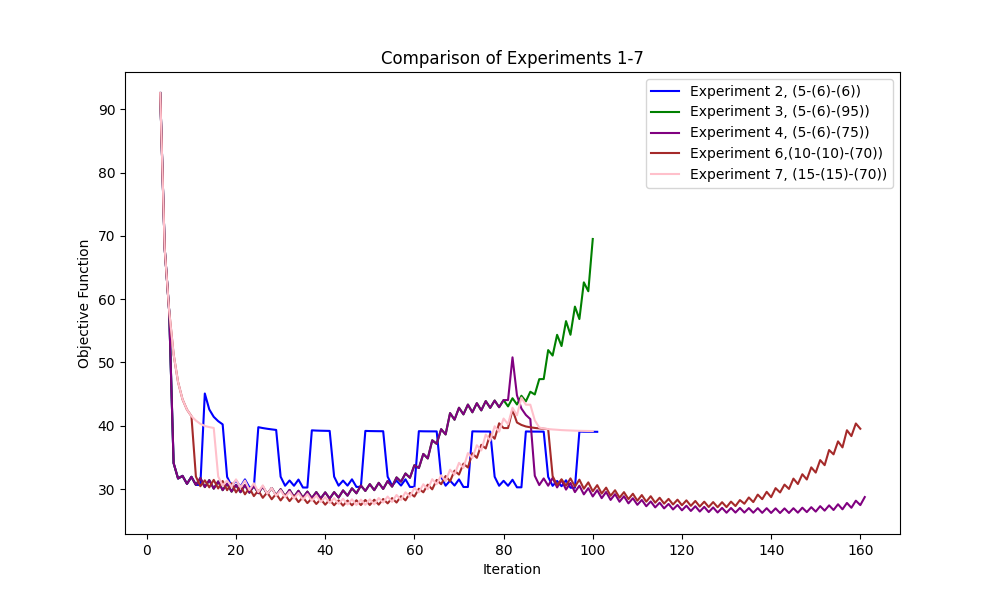

In [9]:
import matplotlib.pyplot as plt

start_index = 2

plt.figure(figsize=(10, 6))

plt.plot(experiment_2_history[0][start_index:], experiment_2_history[1][start_index:], label='Experiment 2, (5-(6)-(6))', color='blue')
plt.plot(experiment_3_history[0][start_index:], experiment_3_history[1][start_index:], label='Experiment 3, (5-(6)-(95))', color='green')
plt.plot(experiment_4_history[0][start_index:], experiment_4_history[1][start_index:], label='Experiment 4, (5-(6)-(75))', color='purple')
plt.plot(experiment_5_history[0][start_index:], experiment_5_history[1][start_index:], label='Experiment 6,(10-(10)-(70))', color='brown')
plt.plot(experiment_6_history[0][start_index:], experiment_6_history[1][start_index:], label='Experiment 7, (15-(15)-(70))', color='pink')

plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('Comparison of Experiments 1-7')

plt.legend()

plt.show()


Let's see the first experiment result

<img src="40x40_(5-(6)-(6)).gif">
